In [1]:
#import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 

In [2]:
# read in cleaned CSV
filepath = Path('../massive.csv')
massive = pd.read_csv(filepath)
massive = massive.sample(n=15000)

In [3]:
massive.head(1)

,id,title,audienceScore,tomatoMeter,reviewId,creationDate,criticName,isTopCritic,reviewState,publicatioName,reviewText,scoreSentiment,delta
355619,fist_fight_2017,Fist Fight,40.0,25.0,2379300,2017-02-16,Richard Roeper,True,rotten,Chicago Sun-Times,"So ugly, so mean-spirited, so bereft of laughs...",NEGATIVE,-15.0


In [4]:
# Dropping columns including audienceScore because it could unfairly help the model predict the delta. Leaving tomatoMeter to give the model a base of where the delta could be.
massive = massive.drop(columns=['id', 'reviewId', 'creationDate', 'isTopCritic', 'reviewState', 'audienceScore'])

In [5]:
massive.isnull().sum()

title             0
tomatoMeter       0
criticName        0
publicatioName    0
reviewText        0
scoreSentiment    0
delta             0
dtype: int64

In [6]:
# Dropping duplicates
massive = massive.drop_duplicates(subset='reviewText', keep='first')
# Checking for duplicates
dup_df = massive.apply(lambda x: x.duplicated()).sum()
dup_df

title              7193
tomatoMeter       14881
criticName        11950
publicatioName    13485
reviewText            0
scoreSentiment    14979
delta             14859
dtype: int64

<AxesSubplot:xlabel='publicatioName', ylabel='Count'>

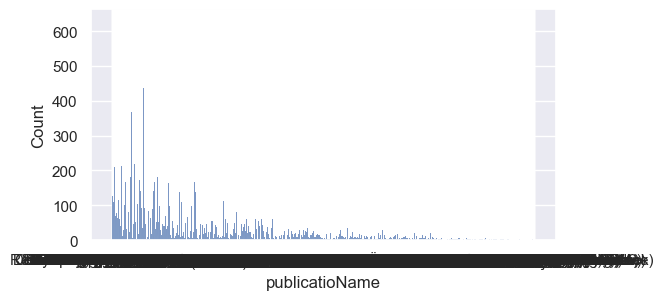

In [370]:
sns.set(rc = {'figure.figsize':(6,3)})
sns.histplot(data=massive, x='publicatioName')

<AxesSubplot:xlabel='criticName', ylabel='Count'>

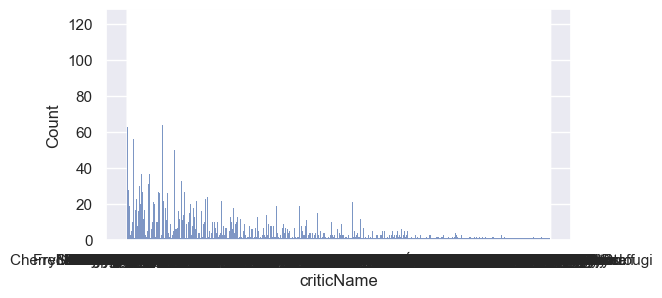

In [151]:
sns.set(rc = {'figure.figsize':(6,3)})
sns.histplot(data=massive, x='criticName')

array([[<AxesSubplot:title={'center':'delta'}>]], dtype=object)

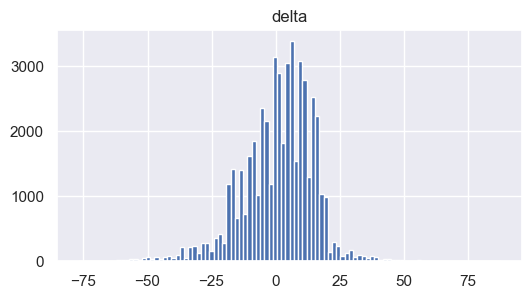

In [372]:
massive.hist(column='delta', bins=100)

In [7]:
# define a function to process text on the data
lemmatizer = WordNetLemmatizer()
import re
def process_text(text): 
    sw = set(stopwords.words('english')) 
    regex = re.compile("[^a-zA-Z ]") 
    re_clean = regex.sub('', text) 
    words = word_tokenize(re_clean) 
    lem = [lemmatizer.lemmatize(word) for word in words] 
    output = ' '.join([word.lower() for word in lem if word.lower() not in sw]) 
    return output

In [8]:
# use a lambda x function to apple process text on the whole column.
massive['reviewText'] = massive['reviewText'].apply(lambda x: process_text(x))

In [9]:
# tfidf vectorizer for sentiment model
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(massive['reviewText'])
y = massive['scoreSentiment']

In [10]:
# Split the data into training and testing sets for sentiment model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Choose a machine learning model (e.g., Logistic Regression) and train it
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [11]:
model.score(X_train, y_train)

0.8230529595015577

In [12]:
model.score(X_test, y_test)

0.7514682327816338

In [13]:
# Creating a dataframe made of the vectorized review text for the linear model
massive_features = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names())

C:\Users\Dan\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
massive_features.head(2)

,aaron,abandon,abandoned,ability,able,aboard,abrams,abrupt,absence,absent,...,youngster,youre,youth,youthful,youve,zack,zany,zero,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Need to rename column because title is also a column in massive_features
massive = massive.rename(columns={'title': 'title_'})

In [16]:
# Vectorizing original df to dense array for linear model
tfidf_dense = tfidf_vectorizer.fit_transform(massive['reviewText']).todense()

# Naming columns for each vectorized word and combining with original massive dataframe
new_cols = tfidf_vectorizer.get_feature_names()
combined = massive.join(pd.DataFrame(tfidf_dense, columns=new_cols))

C:\Users\Dan\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
# Dropping review text now that vectorized words are all columns
combined = combined.drop(columns=['reviewText'])

In [18]:
# Fill the nulls in all of the word columns with 0
combined = combined.fillna(0)

In [19]:
combined.isnull().sum().head(9)

title_            0
tomatoMeter       0
criticName        0
publicatioName    0
scoreSentiment    0
delta             0
aaron             0
abandon           0
abandoned         0
dtype: int64

In [20]:
# Renaming the least-appearing critics as Other to be encoded as the same critic later
counts = combined.criticName.value_counts()
threshold = combined.criticName.isin(counts.index[counts<16])
combined.loc[threshold, 'criticName'] = 'Other'
combined['criticName'].value_counts()

Other                  8822
Dennis Schwartz         123
Jeffrey M. Anderson      89
Roger Ebert              88
David Nusair             82
                       ... 
Andrea Chase             16
Geoffrey Macnab          16
Scott Nash               16
Jack Mathews             16
Eddie Harrison           16
Name: criticName, Length: 218, dtype: int64

In [21]:
# Repeat for publications
counts = combined.publicatioName.value_counts()
threshold = combined.publicatioName.isin(counts.index[counts<12])
combined.loc[threshold, 'publicatioName'] = 'Other'
combined['publicatioName'].value_counts()

Other                           4223
New York Times                   214
Variety                          164
Los Angeles Times                158
Washington Post                  129
                                ... 
Ebert & Roeper                    12
film-authority.com                12
Kansas City Kansan                12
SF Weekly                         12
Worcester Telegram & Gazette      12
Name: publicatioName, Length: 316, dtype: int64

In [22]:
combined.head(1)

,title_,tomatoMeter,criticName,publicatioName,scoreSentiment,delta,aaron,abandon,abandoned,ability,...,youngster,youre,youth,youthful,youve,zack,zany,zero,zombie,zone
355619,Fist Fight,25.0,Richard Roeper,Chicago Sun-Times,NEGATIVE,-15.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# list of columns to dummy
categorical_cols = ['title_', 'criticName', 'publicatioName', 'scoreSentiment'] 
# get dummies on categorical columns
combined = pd.get_dummies(combined, columns = categorical_cols)

In [24]:
X = combined.drop(columns=['delta'])
y = combined['delta']

In [25]:
X.isnull().sum().sum()

0

In [26]:
y.isnull().sum()

0

In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [28]:
X_train.isnull().sum().sum()

0

In [29]:
# Scaling X
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [30]:
pca = PCA(n_components=500)
X_train_p = pca.fit_transform(X_train_sc)
X_test_p = pca.transform(X_test_sc)

In [31]:
# Choose a machine learning model (e.g., Logistic Regression) and train it
model = LinearRegression()
model.fit(X_train_p, y_train)

LinearRegression()

In [32]:
model.score(X_train_p, y_train)

0.28077819576737584

In [33]:
model.score(X_test_p, y_test)

0.1758836524732681

In [34]:
predictions = model.predict(X_test_p)

In [42]:
print(predictions[100:120])
print(y_test[100:120])

[-3.56296151 -4.66554148  1.13050078  9.03154539 -5.67624745  6.25023458
  4.45586076  4.92743838  1.08207383 -4.10322991  7.1443801   5.96869097
  2.84419009 11.59766563  3.68576251 14.24818512  8.32193283  3.32009553
 -1.29936089  3.3962823 ]
486172    -1.0
775342   -13.0
458534     5.0
504301    13.0
206296     6.0
944304    30.0
789519    -3.0
138129    10.0
267602     6.0
585204   -21.0
119205    14.0
657993     3.0
883085     4.0
400970     5.0
910977    -3.0
54238     13.0
470976    19.0
741257     1.0
638701    -7.0
8692       6.0
Name: delta, dtype: float64


In [43]:
predictions.mean()

0.9831749268123526

In [39]:
predictions.min()

-29.810990313343122

In [44]:
y_test.mean()

0.9017618793379605

In [41]:
y_test.min()

-64.0

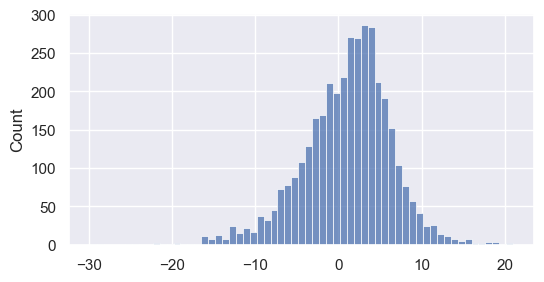

In [49]:
sns.set(rc = {'figure.figsize':(6,3)})
sns.histplot(data=predictions)
plt.savefig('tfidf_linear_predictions.png')

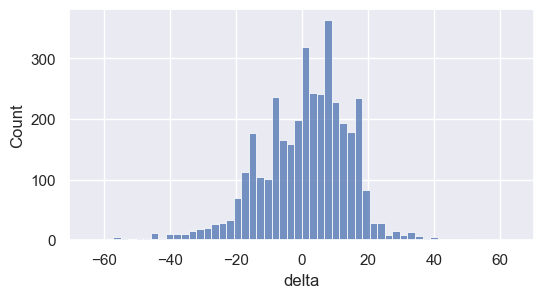

In [50]:
sns.set(rc = {'figure.figsize':(6,3)})
sns.histplot(data=y_test)
plt.savefig('tfidf_linear_ytest.png')

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
r2 = r2_score(y_test, predictions)
r2

0.1758836524732681